In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [2]:
min = pd.read_csv('min_temperature.csv')
pr = pd.read_csv('pr_temperature.csv')
max = pd.read_csv('max_temperature.csv')
avg = pd.read_csv('avg_temperature.csv')

In [3]:
min = min.rename(columns={'Manchester':'man_min','Birmingham':'bir_min','Newcastle':'new_min'})
pr = pr.rename(columns={'Manchester':'man_pr','Birmingham':'bir_pr','Newcastle':'new_pr'})
max = max.rename(columns={'Manchester':'man_max','Birmingham':'bir_max','Newcastle':'new_max'})
avg = avg.rename(columns={'Manchester':'man_avg','Birmingham':'bir_avg','Newcastle':'new_avg'})

In [4]:
pr = pr[['date','man_pr','bir_pr','new_pr']]
max = max[['date','man_max','bir_max','new_max']]
avg = avg[['date','man_avg','bir_avg','new_avg']]

In [5]:
dat = min.merge(pr,how='left',on='date')
dat = dat.merge(max,how='left',on='date')
dat = dat.merge(avg,how='left',on='date')

In [6]:
dat

,date,year,month,day,man_min,bir_min,new_min,man_pr,bir_pr,new_pr,man_max,bir_max,new_max,man_avg,bir_avg,new_avg
0,1990-12-01,1990,12,1,-0.292701,0.124943,1.153770,0.006835,0.005998,0.100482,3.223865,3.338980,3.433901,1.978864,2.200105,2.675202
1,1990-12-02,1990,12,2,-3.756351,-1.561012,-1.418777,6.635946,6.276577,4.684137,3.794656,3.296632,5.941734,-0.299725,0.641068,1.138947
2,1990-12-03,1990,12,3,3.845803,3.364040,5.109035,2.435697,2.196458,0.364569,8.410811,8.505958,7.743710,7.262019,7.484708,6.377828
3,1990-12-04,1990,12,4,5.880041,6.782277,3.983124,9.724846,0.291889,1.180843,11.229656,10.872864,10.846328,8.681782,9.051638,7.530291
4,1990-12-05,1990,12,5,8.422891,10.245434,6.296820,6.544029,0.015334,0.080074,11.849818,12.504953,12.350000,10.555747,11.191326,9.262354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14325,2020-12-26,2020,12,26,4.746957,4.343889,4.040102,16.877125,0.989172,1.628090,7.185665,7.645719,6.416586,6.277648,6.415125,5.461735
14326,2020-12-27,2020,12,27,0.293356,2.650525,-0.721425,2.279630,0.797624,0.247116,6.454095,6.664951,4.718904,3.318828,4.665326,2.061707
14327,2020-12-28,2020,12,28,1.796309,2.868455,-0.927460,31.220827,12.316765,7.530469,11.397823,11.551820,10.461271,6.319577,7.193522,2.891044
14328,2020-12-29,2020,12,29,5.997531,6.619177,4.451486,9.730869,1.348545,5.975148,10.871727,11.366843,10.005295,7.223864,7.770314,6.314470


In [7]:
death = pd.read_csv('death.csv')

In [8]:
death = death.rename(columns={'time':'date'})

In [96]:
man = dat[['date','year','month','day','man_min','man_max','man_avg','man_pr']]
bir = dat[['date','year','month','day','bir_min','bir_max','bir_avg','bir_pr']]
new = dat[['date','year','month','day','new_min','new_max','new_avg','new_pr']]

In [10]:
death_man = death[death.Region_Name == 'North West']
death_man

,date,Region_Name,Daily_Deaths,sex_rate,death_under65,death_65_74,death_75_84,death_over85
9,1981-01-01,North West,261,0.86,67,78,78,38
14,1981-01-02,North West,282,0.84,71,67,96,48
26,1981-01-03,North West,295,1.12,60,95,93,47
31,1981-01-04,North West,227,0.94,43,60,83,41
43,1981-01-05,North West,300,0.84,72,74,104,50
...,...,...,...,...,...,...,...,...
145558,2020-12-26,North West,256,0.90,41,48,73,94
145568,2020-12-27,North West,248,1.08,34,38,92,84
145576,2020-12-28,North West,259,1.09,37,56,78,88
145582,2020-12-30,North West,220,0.77,37,41,68,74


In [11]:
death_bir = death[death.Region_Name == 'West Midlands']
death_bir

,date,Region_Name,Daily_Deaths,sex_rate,death_under65,death_65_74,death_75_84,death_over85
7,1981-01-01,West Midlands,186,0.98,55,40,58,33
10,1981-01-02,West Midlands,168,1.13,38,44,65,21
20,1981-01-03,West Midlands,169,0.88,34,53,53,29
33,1981-01-04,West Midlands,198,0.85,35,46,73,44
40,1981-01-05,West Midlands,157,0.94,43,34,46,34
...,...,...,...,...,...,...,...,...
145554,2020-12-26,West Midlands,216,1.12,32,42,59,83
145569,2020-12-27,West Midlands,217,0.84,29,32,74,82
145570,2020-12-28,West Midlands,196,0.88,24,22,63,87
145587,2020-12-30,West Midlands,234,0.98,33,38,61,102


In [95]:
death_new = death[death.Region_Name == 'North East']
death_new

,date,Region_Name,Daily_Deaths,sex_rate,death_under65,death_65_74,death_75_84,death_over85
0,1981-01-01,North East,108,1.30,31,28,38,11
17,1981-01-02,North East,112,1.00,31,26,34,21
22,1981-01-03,North East,113,0.88,26,21,45,21
32,1981-01-04,North East,95,0.79,30,20,32,13
44,1981-01-05,North East,101,0.94,27,25,30,19
...,...,...,...,...,...,...,...,...
145553,2020-12-26,North East,103,1.19,17,14,33,39
145560,2020-12-27,North East,106,0.80,15,24,33,34
145579,2020-12-28,North East,115,1.09,16,26,36,37
145585,2020-12-30,North East,81,1.38,11,14,30,26


In [97]:
death_new = death_new.merge(new,on='date',how='left')

In [14]:
death_bir = death_bir.merge(bir,on='date',how='left')

In [15]:
death_man = death_man.merge(man,on='date',how='left')

In [16]:
death_man_summer = death_man[death_man['month'].between(6.0,8.0)]

In [17]:
death_bir_summer = death_bir[death_bir['month'].between(6.0,8.0)]

In [98]:
death_new_summer = death_new[death_new['month'].between(6.0,8.0)]

In [99]:
death_new_summer

,date,Region_Name,Daily_Deaths,sex_rate,death_under65,death_65_74,death_75_84,death_over85,year,month,day,new_min,new_max,new_avg,new_pr
151,1981-06-01,North East,85,1.02,24,25,23,13,1981.0,6.0,1.0,6.399064,9.213539,7.722356,0.347320
152,1981-06-02,North East,72,1.25,24,16,25,7,1981.0,6.0,2.0,6.864255,9.638519,8.188110,0.290970
153,1981-06-03,North East,80,1.11,23,15,35,7,1981.0,6.0,3.0,6.557695,9.913733,8.120584,0.399134
154,1981-06-04,North East,71,0.92,15,23,26,7,1981.0,6.0,4.0,7.237544,10.094293,8.518219,0.174634
155,1981-06-05,North East,77,1.20,19,24,24,10,1981.0,6.0,5.0,7.330478,10.372019,8.877575,0.431654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14433,2020-08-26,North East,71,0.92,11,15,22,23,2020.0,8.0,26.0,15.078363,23.775600,19.441055,0.193756
14434,2020-08-27,North East,60,1.14,9,13,17,21,2020.0,8.0,27.0,11.456134,19.858368,15.987433,0.022009
14435,2020-08-28,North East,74,1.06,15,16,17,26,2020.0,8.0,28.0,11.896063,22.073442,17.499405,8.274512
14436,2020-08-29,North East,71,0.87,15,7,21,28,2020.0,8.0,29.0,9.421947,16.246082,12.560566,0.159578


In [100]:
death_new_summer['new_max'] = death_new_summer['new_max'].fillna(np.mean(death_new_summer['new_max']))

<ipython-input-100-a7393acc5173>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  death_new_summer['new_max'] = death_new_summer['new_max'].fillna(np.mean(death_new_summer['new_max']))


In [21]:
death_bir_summer['bir_max'] = death_bir_summer['bir_max'].fillna(np.mean(death_bir_summer['bir_max']))

<ipython-input-21-751b9115fb7e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  death_bir_summer['bir_max'] = death_bir_summer['bir_max'].fillna(np.mean(death_bir_summer['bir_max']))


In [22]:
death_man_summer['man_max'] = death_man_summer['man_max'].fillna(np.mean(death_man_summer['man_max']))

<ipython-input-22-bc5ba61c7065>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  death_man_summer['man_max'] = death_man_summer['man_max'].fillna(np.mean(death_man_summer['man_max']))


In [101]:
death_new_summer

,date,Region_Name,Daily_Deaths,sex_rate,death_under65,death_65_74,death_75_84,death_over85,year,month,day,new_min,new_max,new_avg,new_pr
151,1981-06-01,North East,85,1.02,24,25,23,13,1981.0,6.0,1.0,6.399064,9.213539,7.722356,0.347320
152,1981-06-02,North East,72,1.25,24,16,25,7,1981.0,6.0,2.0,6.864255,9.638519,8.188110,0.290970
153,1981-06-03,North East,80,1.11,23,15,35,7,1981.0,6.0,3.0,6.557695,9.913733,8.120584,0.399134
154,1981-06-04,North East,71,0.92,15,23,26,7,1981.0,6.0,4.0,7.237544,10.094293,8.518219,0.174634
155,1981-06-05,North East,77,1.20,19,24,24,10,1981.0,6.0,5.0,7.330478,10.372019,8.877575,0.431654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14433,2020-08-26,North East,71,0.92,11,15,22,23,2020.0,8.0,26.0,15.078363,23.775600,19.441055,0.193756
14434,2020-08-27,North East,60,1.14,9,13,17,21,2020.0,8.0,27.0,11.456134,19.858368,15.987433,0.022009
14435,2020-08-28,North East,74,1.06,15,16,17,26,2020.0,8.0,28.0,11.896063,22.073442,17.499405,8.274512
14436,2020-08-29,North East,71,0.87,15,7,21,28,2020.0,8.0,29.0,9.421947,16.246082,12.560566,0.159578


In [24]:
np.corrcoef(death_new_summer['new_max'],death_new_summer['death_over85'])

array([[1.        , 0.05949945],
       [0.05949945, 1.        ]])

In [25]:
np.corrcoef(death_man_summer['man_max'],death_man_summer['death_over85'])

array([[1.        , 0.08112566],
       [0.08112566, 1.        ]])

In [26]:
np.corrcoef(death_bir_summer['bir_max'],death_bir_summer['death_over85'])

array([[1.        , 0.09324117],
       [0.09324117, 1.        ]])

In [ ]:
death_new_summer

In [102]:
death_new_summer=death_new_summer.set_index('date')

In [28]:
death_man_summer=death_man_summer.set_index('date')

In [29]:
death_bir_summer=death_bir_summer.set_index('date')

In [30]:
death_man_summer = death_man_summer[['year','month','day','man_min','man_max','man_avg','man_pr','death_over85']]
death_bir_summer = death_bir_summer[['year','month','day','bir_min','bir_max','bir_avg','bir_pr','death_over85']]

In [103]:
death_new_summer = death_new_summer[['year','month','day','new_min','new_max','new_avg','new_pr','death_over85']]
death_new_summer

,year,month,day,new_min,new_max,new_avg,new_pr,death_over85
date,,,,,,,,
1981-06-01,1981.0,6.0,1.0,6.399064,9.213539,7.722356,0.347320,13
1981-06-02,1981.0,6.0,2.0,6.864255,9.638519,8.188110,0.290970,7
1981-06-03,1981.0,6.0,3.0,6.557695,9.913733,8.120584,0.399134,7
1981-06-04,1981.0,6.0,4.0,7.237544,10.094293,8.518219,0.174634,7
1981-06-05,1981.0,6.0,5.0,7.330478,10.372019,8.877575,0.431654,10
...,...,...,...,...,...,...,...,...
2020-08-26,2020.0,8.0,26.0,15.078363,23.775600,19.441055,0.193756,23
2020-08-27,2020.0,8.0,27.0,11.456134,19.858368,15.987433,0.022009,21
2020-08-28,2020.0,8.0,28.0,11.896063,22.073442,17.499405,8.274512,26


<AxesSubplot:>

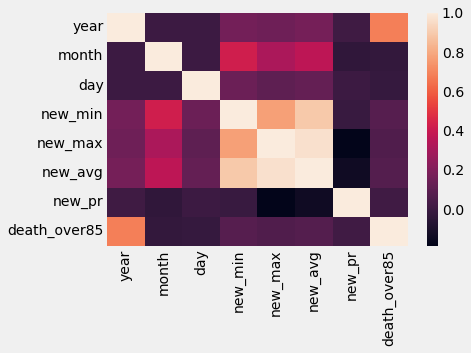

In [104]:
coeff = death_new_summer.corr() # 相关性
sns.heatmap(coeff)
# plt.savefig('heatmap.pdf')

In [ ]:
coeff_ = death_man_summer.loc[:,['year','month','day','man_min','man_max','man_avg','man_pr','death_over85']].corr() # 相关性
sns.heatmap(coeff_)

In [ ]:
coeff__ = death_bir_summer.loc[:,['year','month','day','bir_min','bir_max','bir_avg','bir_pr','death_over85']].corr() # 相关性
sns.heatmap(coeff__)

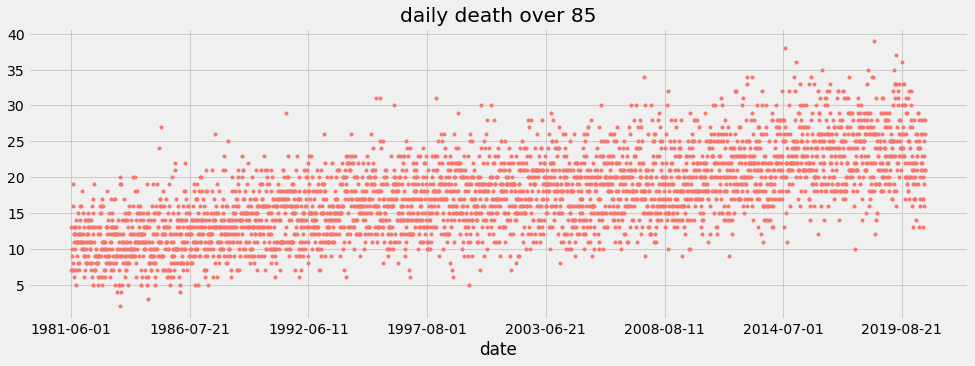

In [105]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = death_new_summer['death_over85'].plot(style='.', figsize=(15,5), color=color_pal[0], title='daily death over 85')

<AxesSubplot:xlabel='date'>

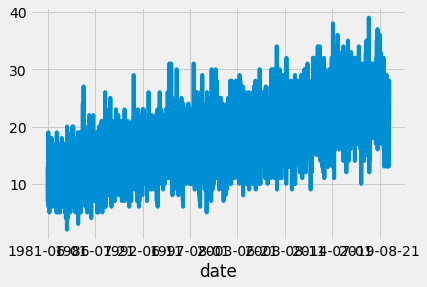

In [38]:
death_new_summer['death_over85'].plot()

In [39]:
from statsmodels.tsa.stattools import kpss

ss = death_new_summer['death_over85']

kpss(ss)

/Users/liuzhenrui/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


(9.077661886841248,
 0.01,
 36,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [40]:
from statsmodels.stats.diagnostic import acorr_ljungbox as ljbox

In [41]:
ss = death_new_summer['rolling_death']

ljbox(ss, lags=1)

KeyError: 'rolling_death'

In [106]:
death_new_summer

,year,month,day,new_min,new_max,new_avg,new_pr,death_over85
date,,,,,,,,
1981-06-01,1981.0,6.0,1.0,6.399064,9.213539,7.722356,0.347320,13
1981-06-02,1981.0,6.0,2.0,6.864255,9.638519,8.188110,0.290970,7
1981-06-03,1981.0,6.0,3.0,6.557695,9.913733,8.120584,0.399134,7
1981-06-04,1981.0,6.0,4.0,7.237544,10.094293,8.518219,0.174634,7
1981-06-05,1981.0,6.0,5.0,7.330478,10.372019,8.877575,0.431654,10
...,...,...,...,...,...,...,...,...
2020-08-26,2020.0,8.0,26.0,15.078363,23.775600,19.441055,0.193756,23
2020-08-27,2020.0,8.0,27.0,11.456134,19.858368,15.987433,0.022009,21
2020-08-28,2020.0,8.0,28.0,11.896063,22.073442,17.499405,8.274512,26


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


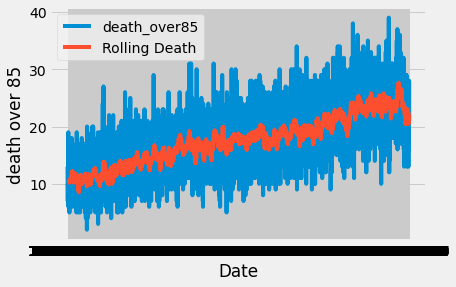

In [321]:
# newcattle
rolling_death = death_new_summer['death_over85'].rolling(20).mean()
plt.plot(death_new_summer.index, death_new_summer['death_over85'])
plt.plot(death_new_summer.index, rolling_death)
plt.xlabel('Date')
plt.ylabel('death over 85')
plt.legend(['death_over85','Rolling Death'])
plt.show()

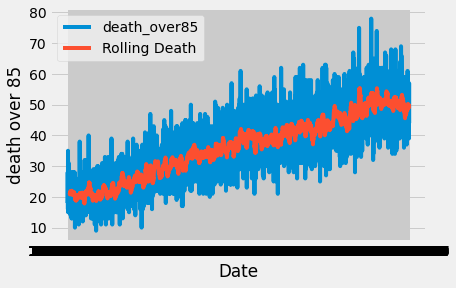

In [45]:
# birmingham
rolling_death_bir = death_bir_summer['death_over85'].rolling(20).mean()
plt.plot(death_bir_summer.index, death_bir_summer['death_over85'])
plt.plot(death_bir_summer.index, rolling_death_bir)
plt.xlabel('Date')
plt.ylabel('death over 85')
plt.legend(['death_over85','Rolling Death'])
plt.show()

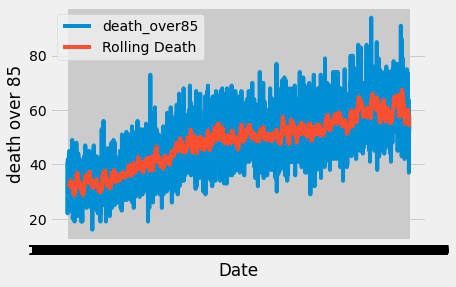

In [46]:
# Manchester
rolling_death_man = death_man_summer['death_over85'].rolling(20).mean()
plt.plot(death_man_summer.index, death_man_summer['death_over85'])
plt.plot(death_man_summer.index, rolling_death_man)
plt.xlabel('Date')
plt.ylabel('death over 85')
plt.legend(['death_over85','Rolling Death'])
plt.show()

In [47]:
death_bir_summer['rolling_death'] = rolling_death_bir

In [48]:
death_man_summer['rolling_death'] = rolling_death_man

In [108]:
death_new_summer['rolling_death'] = rolling_death

In [109]:
death_new_summer.iloc[:19, [-1]]

,rolling_death
date,
1981-06-01,NaN
1981-06-02,NaN
1981-06-03,NaN
1981-06-04,NaN
1981-06-05,NaN
1981-06-06,NaN
1981-06-07,NaN
1981-06-08,NaN
1981-06-09,NaN


In [110]:
death_new_summer['rolling_death'] = death_new_summer['rolling_death'].fillna(0)

In [52]:
death_bir_summer['rolling_death'] = death_bir_summer['rolling_death'].fillna(0)

In [53]:
death_man_summer['rolling_death'] = death_man_summer['rolling_death'].fillna(0)

In [111]:
death_new_summer

,year,month,day,new_min,new_max,new_avg,new_pr,death_over85,rolling_death
date,,,,,,,,,
1981-06-01,1981.0,6.0,1.0,6.399064,9.213539,7.722356,0.347320,13,0.00
1981-06-02,1981.0,6.0,2.0,6.864255,9.638519,8.188110,0.290970,7,0.00
1981-06-03,1981.0,6.0,3.0,6.557695,9.913733,8.120584,0.399134,7,0.00
1981-06-04,1981.0,6.0,4.0,7.237544,10.094293,8.518219,0.174634,7,0.00
1981-06-05,1981.0,6.0,5.0,7.330478,10.372019,8.877575,0.431654,10,0.00
...,...,...,...,...,...,...,...,...,...
2020-08-26,2020.0,8.0,26.0,15.078363,23.775600,19.441055,0.193756,23,21.20
2020-08-27,2020.0,8.0,27.0,11.456134,19.858368,15.987433,0.022009,21,21.05
2020-08-28,2020.0,8.0,28.0,11.896063,22.073442,17.499405,8.274512,26,21.55


In [112]:
death_new_summer.iloc[:19, [-1]] = death_new_summer.iloc[20:39, [-1]]

In [59]:
death_bir_summer.iloc[:19, [-1]] = death_bir_summer.iloc[20:39, [-1]]

In [60]:
death_man_summer.iloc[:19, [-1]] = death_man_summer.iloc[20:39, [-1]]

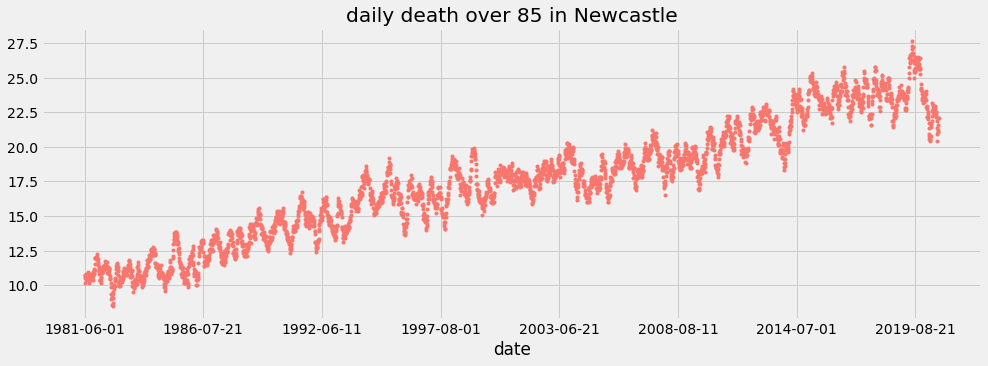

In [113]:
death_new_summer.rolling_death.plot(style='.', figsize=(15,5), color=color_pal[0], title='daily death over 85 in Newcastle')
plt.tight_layout
plt.savefig('daily_death_new.png')

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

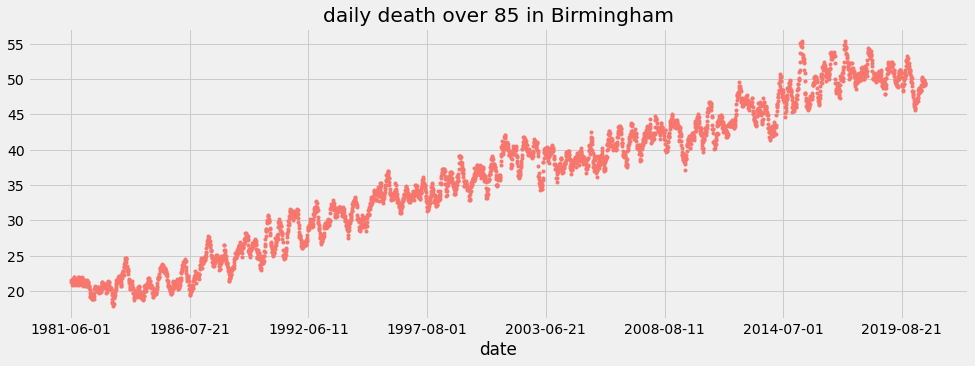

In [68]:
death_bir_summer.rolling_death.plot(style='.', figsize=(15,5), color=color_pal[0], title='daily death over 85 in Birmingham')
plt.tight_layout

In [ ]:
sns.scatterplot()

In [ ]:
death_new_summer['rolling_death'] = death_new_summer['rolling_death'].astype(int)
death_bir_summer['rolling_death'] = death_bir_summer['rolling_death'].astype(int)
death_man_summer['rolling_death'] = death_man_summer['rolling_death'].astype(int)

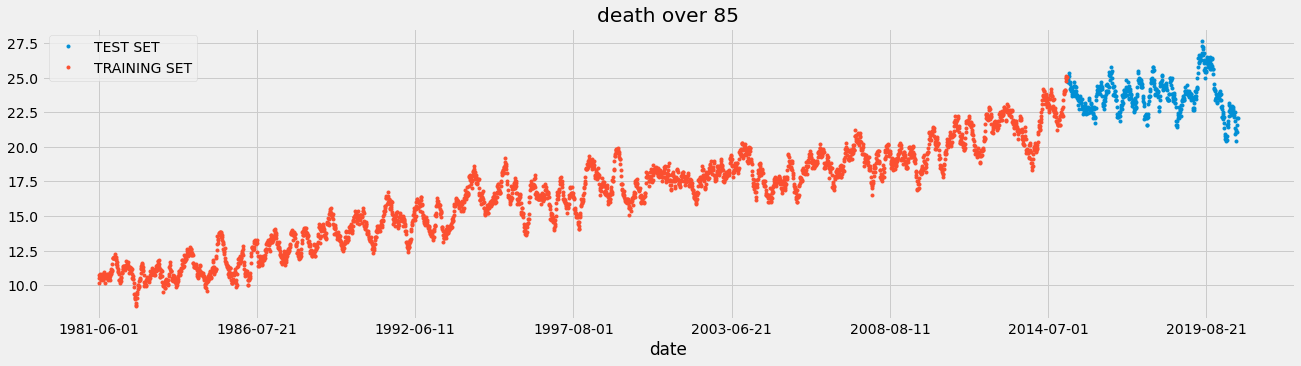

In [114]:
temp = death_new_summer[['rolling_death']]
split_date = '2015-01-01'
temp_train = temp.loc[temp.index < split_date].copy()
temp_test = temp.loc[temp.index >= split_date].copy()
_ = temp_test.rename(columns={'rolling_death': 'TEST SET'})\
    .join(temp_train.rename(columns={'rolling_death': 'TRAINING SET'}),how='outer') \
    .plot(figsize=(20,5), title='death over 85', style='.')
# plt.savefig('death_new.pdf')

<AxesSubplot:title={'center':'death over 85'}, xlabel='date'>

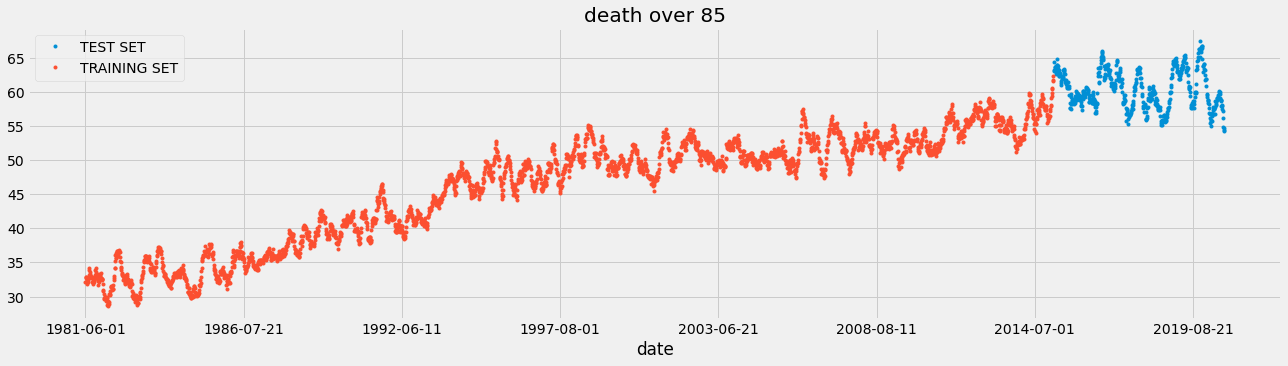

In [71]:
temp_man = death_man_summer[['rolling_death']]
split_date = '2015-01-01'
temp_man_train = temp_man.loc[temp_man.index < split_date].copy()
temp_man_test = temp_man.loc[temp_man.index >= split_date].copy()
temp_man_test.rename(columns={'rolling_death': 'TEST SET'})\
    .join(temp_man_train.rename(columns={'rolling_death': 'TRAINING SET'}),how='outer') \
    .plot(figsize=(20,5), title='death over 85', style='.')

<AxesSubplot:title={'center':'death over 85'}, xlabel='date'>

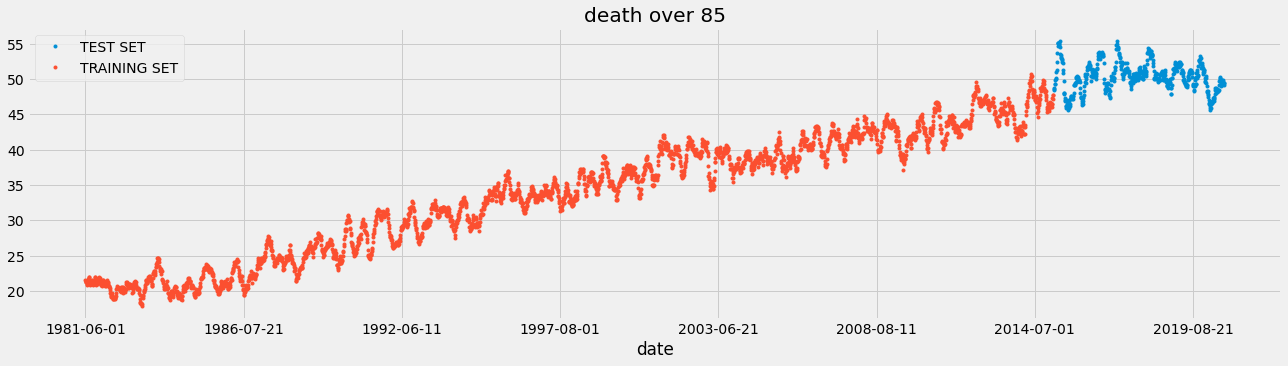

In [72]:
temp_bir = death_bir_summer[['rolling_death']]
split_date = '2015-01-01'
temp_bir_train = temp_bir.loc[temp_bir.index < split_date].copy()
temp_bir_test = temp_bir.loc[temp_bir.index >= split_date].copy()
temp_bir_test.rename(columns={'rolling_death': 'TEST SET'})\
    .join(temp_bir_train.rename(columns={'rolling_death': 'TRAINING SET'}),how='outer') \
    .plot(figsize=(20,5), title='death over 85', style='.')

In [73]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb 
from sklearn import model_selection

In [293]:
death_bir_summer

,year,month,day,bir_min,bir_max,bir_avg,bir_pr,death_over85,rolling_death
date,,,,,,,,,
1981-06-01,1981.0,6.0,1.0,7.138943,12.911530,9.613237,3.050909,18,21.50
1981-06-02,1981.0,6.0,2.0,7.945549,12.626352,10.162156,15.398354,20,21.30
1981-06-03,1981.0,6.0,3.0,7.956182,15.019295,11.262386,1.237225,28,21.25
1981-06-04,1981.0,6.0,4.0,8.036394,13.427114,10.329688,2.681326,21,21.25
1981-06-05,1981.0,6.0,5.0,8.287448,12.977115,10.331379,30.204716,16,21.20
...,...,...,...,...,...,...,...,...,...
2020-08-26,2020.0,8.0,26.0,15.059542,27.245346,21.157284,0.003642,56,49.90
2020-08-27,2020.0,8.0,27.0,15.623131,26.010891,20.781651,0.008886,39,49.30
2020-08-28,2020.0,8.0,28.0,15.372007,30.820614,22.854008,0.104716,46,49.10


In [336]:
features = death_bir_summer.drop(['rolling_death','death_over85'], axis = 1) 
targets = death_bir_summer['rolling_death']

In [117]:
features_man = death_man_summer.drop(['rolling_death','death_over85'], axis = 1) 
targets_man = death_man_summer['rolling_death']

In [295]:
features_bir = death_bir_summer.drop(['rolling_death','death_over85'], axis = 1) 
targets_bir = death_bir_summer['rolling_death']

In [119]:
X_train_man = features_man.loc[death_man_summer.index < split_date].copy()
X_train_test_man = features_man.loc[death_man_summer.index >= split_date].copy()
y_train_man = targets_man.loc[death_man_summer.index < split_date].copy()
y_train_test_man = targets_man.loc[death_man_summer.index >= split_date].copy()

In [296]:
X_train_bir = features_bir.loc[death_bir_summer.index < split_date].copy()
X_train_test_bir = features_bir.loc[death_bir_summer.index >= split_date].copy()
y_train_bir = targets_bir.loc[death_bir_summer.index < split_date].copy()
y_train_test_bir = targets_bir.loc[death_bir_summer.index >= split_date].copy()

In [337]:
X_train = features.loc[death_new_summer.index < split_date].copy()
X_train

,year,month,day,bir_min,bir_max,bir_avg,bir_pr
date,,,,,,,
1981-06-01,1981.0,6.0,1.0,7.138943,12.911530,9.613237,3.050909
1981-06-02,1981.0,6.0,2.0,7.945549,12.626352,10.162156,15.398354
1981-06-03,1981.0,6.0,3.0,7.956182,15.019295,11.262386,1.237225
1981-06-04,1981.0,6.0,4.0,8.036394,13.427114,10.329688,2.681326
1981-06-05,1981.0,6.0,5.0,8.287448,12.977115,10.331379,30.204716
...,...,...,...,...,...,...,...
2014-08-26,2014.0,8.0,26.0,12.883069,25.517294,19.172100,0.010996
2014-08-27,2014.0,8.0,27.0,15.311268,23.433178,19.028023,0.008081
2014-08-28,2014.0,8.0,28.0,13.192980,18.179649,15.752766,0.871827


In [338]:
X_train_test = features.loc[death_new_summer.index >= split_date].copy()
X_train_test

,year,month,day,bir_min,bir_max,bir_avg,bir_pr
date,,,,,,,
2015-06-01,2015.0,6.0,1.0,10.399939,14.856847,12.430069,0.112255
2015-06-02,2015.0,6.0,2.0,8.933125,16.730450,13.579264,0.241628
2015-06-03,2015.0,6.0,3.0,11.781528,17.412830,14.451119,0.841025
2015-06-04,2015.0,6.0,4.0,10.295681,17.116455,13.808937,0.086540
2015-06-05,2015.0,6.0,5.0,9.188057,18.771381,14.302329,0.036387
...,...,...,...,...,...,...,...
2020-08-26,2020.0,8.0,26.0,15.059542,27.245346,21.157284,0.003642
2020-08-27,2020.0,8.0,27.0,15.623131,26.010891,20.781651,0.008886
2020-08-28,2020.0,8.0,28.0,15.372007,30.820614,22.854008,0.104716


In [339]:
y_train = targets.loc[death_new_summer.index < split_date].copy()
y_train

date
1981-06-01    21.50
1981-06-02    21.30
1981-06-03    21.25
1981-06-04    21.25
1981-06-05    21.20
              ...  
2014-08-26    46.50
2014-08-27    47.30
2014-08-28    47.20
2014-08-29    47.80
2014-08-30    47.70
Name: rolling_death, Length: 3060, dtype: float64

In [340]:
y_train_test = targets.loc[death_new_summer.index >= split_date].copy()
y_train_test

date
2015-06-01    48.50
2015-06-02    48.75
2015-06-03    48.60
2015-06-04    49.35
2015-06-05    49.25
              ...  
2020-08-26    49.90
2020-08-27    49.30
2020-08-28    49.10
2020-08-29    49.50
2020-08-30    49.45
Name: rolling_death, Length: 540, dtype: float64

In [83]:
from sklearn.model_selection import GridSearchCV

In [84]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [85]:
from sklearn.model_selection import RandomizedSearchCV

In [86]:
parameters = {
'colsample_bytree':[1.0],
'gamma':[0,0.03,0.1,0.3],
'min_child_weight':[1.0,1.5,6,10],
'learning_rate':[0.3,0.1,0.07,0.001],
'max_depth':[3,5,8,10,50,100],
'n_estimators':[10,100,200,300],
'reg_alpha':[1e-5, 1e-2,  0.75],
'reg_lambda':[1e-5, 1e-2, 0.45],
'subsample':[0.8,0.95]  }
#Lets now fit a XGBOOST model to all the data we have
xgb_new = xgb.XGBRegressor()
gsearch_new = RandomizedSearchCV(estimator=xgb_new, param_distributions=parameters, n_iter=40, scoring='neg_mean_squared_error', n_jobs=-1, cv=3, verbose=2, random_state=1001)
gsearch_new.fit(X_train,y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


/Users/liuzhenrui/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None, max_bin=None,
                                          m...
                   param_distributions={'colsample_bytree': [1.0],
                                       

In [87]:
print('Best: %f using %s'%(gsearch_new.best_score_, gsearch_new.best_params_))

Best: -22.758720 using {'subsample': 0.95, 'reg_lambda': 0.45, 'reg_alpha': 0.01, 'n_estimators': 10, 'min_child_weight': 10, 'max_depth': 3, 'learning_rate': 0.3, 'gamma': 0, 'colsample_bytree': 1.0}


In [342]:
model = xgb.XGBRegressor(subsample=0.95, reg_lambda=0.45,reg_alpha=0.75,
                          n_estimators=300, min_child_weight=6, max_depth=50,
                          learning_rate=0.3, gamma=0.3, colsample_bytree=1.0)
model.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0.3, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.3, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=50, max_leaves=0, min_child_weight=6,
             missing=nan, monotone_constraints='()', n_estimators=300, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0.75, reg_lambda=0.45, ...)

AttributeError: module 'matplotlib.pyplot' has no attribute 'sa'

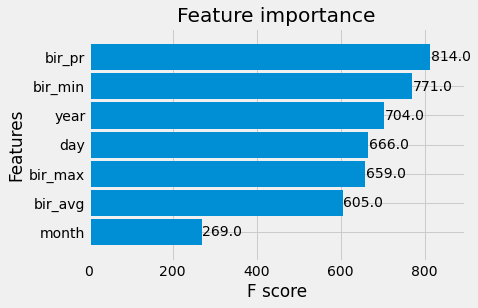

In [343]:
__ = xgb.plot_importance(model, height=0.9)
plt.sa

In [302]:
X_train_test

,year,month,day,new_min,new_max,new_avg,new_pr
date,,,,,,,
2015-06-01,2015.0,6.0,1.0,10.003051,16.156668,12.981271,0.297460
2015-06-02,2015.0,6.0,2.0,7.206343,15.288678,11.967657,0.040607
2015-06-03,2015.0,6.0,3.0,9.710574,17.153021,13.259924,2.920082
2015-06-04,2015.0,6.0,4.0,7.406582,15.709403,12.358000,0.052103
2015-06-05,2015.0,6.0,5.0,8.956901,16.205948,12.992478,0.027766
...,...,...,...,...,...,...,...
2020-08-26,2020.0,8.0,26.0,15.078363,23.775600,19.441055,0.193756
2020-08-27,2020.0,8.0,27.0,11.456134,19.858368,15.987433,0.022009
2020-08-28,2020.0,8.0,28.0,11.896063,22.073442,17.499405,8.274512


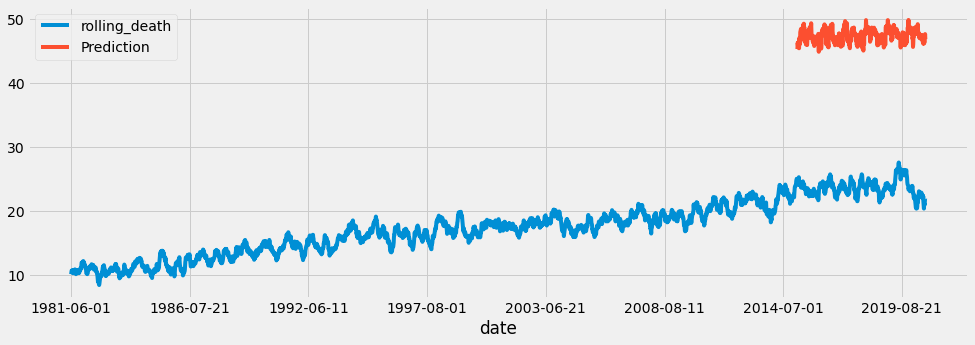

In [344]:
temp_test['Prediction'] = model.predict(X_train_test)
temp_all = pd.concat([temp_train,temp_test], sort=False)
__ = temp_all[['rolling_death','Prediction']].plot(figsize=(15, 5))

In [214]:
temp_test

,rolling_death,Prediction
date,,
2015-06-01,25.05,23.111696
2015-06-02,24.75,21.485998
2015-06-03,24.70,22.668112
2015-06-04,24.65,21.386599
2015-06-05,24.90,22.721039
...,...,...
2020-08-26,21.20,23.056072
2020-08-27,21.05,24.008789
2020-08-28,21.55,23.201067


In [ ]:
xgb_new_man = xgb.XGBRegressor()
gsearch_new_man = RandomizedSearchCV(estimator=xgb_new_man, param_distributions=parameters, n_iter=40, scoring='neg_mean_squared_error', n_jobs=-1, cv=3, verbose=2, random_state=1001)
gsearch_new_man.fit(X_train_man,y_train_man)

In [ ]:
print('Best: %f using %s'%(gsearch_new_man.best_score_, gsearch_new_man.best_params_))

In [367]:
model = xgb.XGBRegressor(subsample=0.95, reg_lambda=0.45,reg_alpha=0.75,
                          n_estimators=300, min_child_weight=6, max_depth=50,
                          learning_rate=0.3, gamma=0.3, colsample_bytree=1.0)
model.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0.3, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.3, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=50, max_leaves=0, min_child_weight=6,
             missing=nan, monotone_constraints='()', n_estimators=300, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0.75, reg_lambda=0.45, ...)

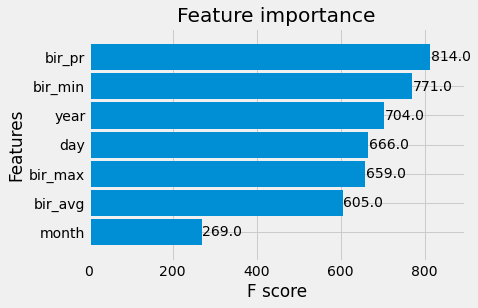

In [368]:
__ = xgb.plot_importance(model, height=0.9)

In [ ]:
temp_man_test['Prediction'] = model_man.predict(X_train_test_man)
temp_all_man = pd.concat([temp_man_train,temp_man_test], sort=False)
__man = temp_all_man[['rolling_death','Prediction']].plot(figsize=(15, 5))

In [323]:
mse = mean_squared_error(y_true=temp_test['rolling_death'], y_pred=temp_test['Prediction'])
# 14.718074529657168
mae = mean_absolute_error(y_true=temp_test['rolling_death'], y_pred=temp_test['Prediction'])
# 2.9980725916891813
mape = mean_absolute_percentage_error(y_true=temp_test['rolling_death'], y_pred=temp_test['Prediction'])
# inf
# 因为 y_true 中含有 0

In [324]:
mse

2.5021483838661442

In [325]:
mae

1.2342817829273365

In [326]:
mape

5.1013528786229925

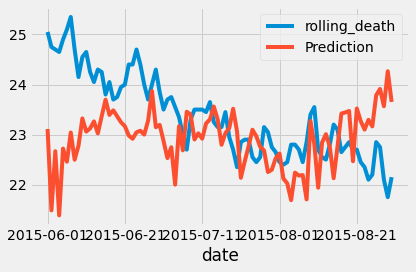

In [128]:
temp_all[(temp_all.index >= '2015-06-01') & (temp_all.index < '2015-09-01')].plot()
plt.tight_layout()

In [151]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor


In [156]:

rfgs_parameters = {
    'n_estimators': [n for n in range(30, 50)],
    'max_depth'   : [n for n in range(2, 6)],
    'max_features': [n for n in range(2, 6)],
    "min_samples_split": [n for n in range(2, 4)],
    "min_samples_leaf": [n for n in range(2, 4)],
    "bootstrap": [True,False]
}


In [152]:
X_train

,year,month,day,new_min,new_max,new_avg,new_pr
date,,,,,,,
1981-06-01,1981.0,6.0,1.0,6.399064,9.213539,7.722356,0.347320
1981-06-02,1981.0,6.0,2.0,6.864255,9.638519,8.188110,0.290970
1981-06-03,1981.0,6.0,3.0,6.557695,9.913733,8.120584,0.399134
1981-06-04,1981.0,6.0,4.0,7.237544,10.094293,8.518219,0.174634
1981-06-05,1981.0,6.0,5.0,7.330478,10.372019,8.877575,0.431654
...,...,...,...,...,...,...,...
2014-08-26,2014.0,8.0,26.0,12.983251,23.390289,18.010584,0.006867
2014-08-27,2014.0,8.0,27.0,12.253713,17.017363,15.132373,0.021093
2014-08-28,2014.0,8.0,28.0,11.215803,15.947785,13.681378,0.085366


In [157]:
rfr_cv = GridSearchCV(RandomForestRegressor(), rfgs_parameters, cv=3, scoring= 'neg_mean_squared_log_error')
rfr_cv.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(),
             param_grid={'bootstrap': [True, False], 'max_depth': [2, 3, 4, 5],
                         'max_features': [2, 3, 4, 5],
                         'min_samples_leaf': [2, 3],
                         'min_samples_split': [2, 3],
                         'n_estimators': [30, 31, 32, 33, 34, 35, 36, 37, 38,
                                          39, 40, 41, 42, 43, 44, 45, 46, 47,
                                          48, 49]},
             scoring='neg_mean_squared_log_error')

In [158]:
print("RFR GridSearch score: "+str(rfr_cv.best_score_))
print("RFR GridSearch params: ")
print(rfr_cv.best_params_)

RFR GridSearch score: -0.02035364625056971
RFR GridSearch params: 
{'bootstrap': False, 'max_depth': 5, 'max_features': 5, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 46}


In [209]:
rfr_val=RandomForestRegressor(n_estimators=100, 
                              criterion='mse',
                              max_depth=50,
                              min_samples_split=20, 
                              min_samples_leaf=3, 
                              min_weight_fraction_leaf=0.0, 
                              max_features='auto', 
                              max_leaf_nodes=None, 
                              min_impurity_decrease=0.0, 
                              bootstrap=True, 
                              oob_score=False,
                              n_jobs=4, 
                              random_state=35, 
                              verbose=0, 
                              warm_start=False)
model_RF_test=rfr_val.fit(X_train,y_train)

/Users/liuzhenrui/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


In [193]:
temp_test__ = temp_test.iloc[:, [0]]

/Users/liuzhenrui/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- bir_avg
- bir_max
- bir_min
- bir_pr
Feature names seen at fit time, yet now missing:
- new_avg
- new_max
- new_min
- new_pr

  warnings.warn(message, FutureWarning)


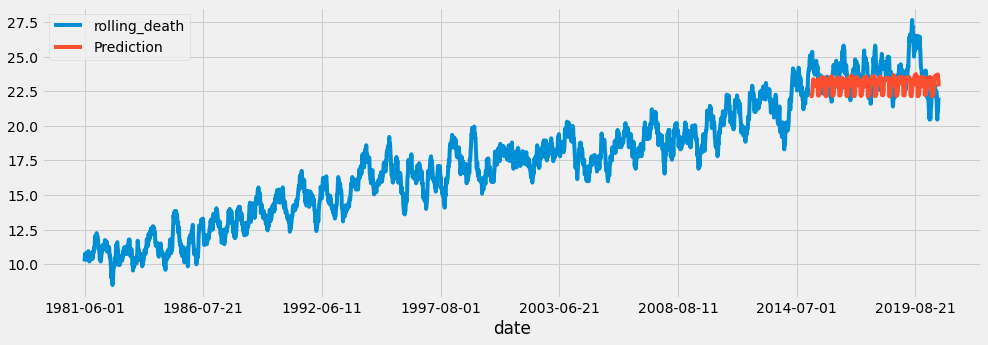

In [365]:
temp_test__['Prediction'] = model_RF_test.predict(X_train_test)
temp_all_ = pd.concat([temp_train,temp_test__], sort=False)
____ = temp_all_[['rolling_death','Prediction']].plot(figsize=(15, 5))

In [178]:
import itertools

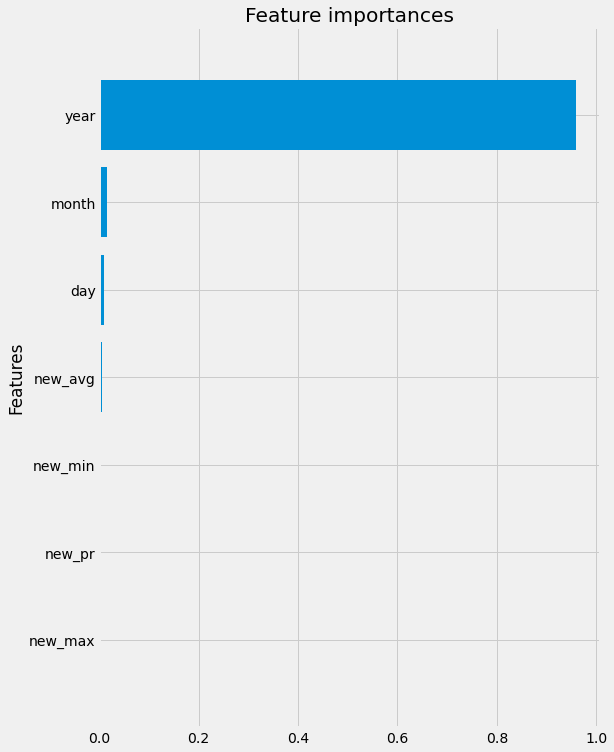

In [211]:
importances = rfr_val.feature_importances_
std = np.std([rfr_val.feature_importances_ for tree in rfr_val.estimators_],
axis=0)
indices = np.argsort(importances)
palette1 = itertools.cycle(sns.color_palette()) # Store the feature ranking
features_ranked=[]
for f in range(X_train.shape[1]):
    features_ranked.append(X_train.columns[indices[f]])
# Plot the feature importances of the forest
plt.figure(figsize=(8,12))
plt.title("Feature importances") 
plt.barh(range(X_train.shape[1]), importances[indices],color=[next(palette1)], align="center") 
plt.yticks(range(X_train.shape[1]), features_ranked) 
plt.ylabel('Features')
plt.ylim([-1, X_train.shape[1]]) 
plt.show()

In [361]:
mse = mean_squared_error(y_true=temp_test['rolling_death'], y_pred=temp_test__['Prediction'])
# 14.718074529657168
mae = mean_absolute_error(y_true=temp_test['rolling_death'], y_pred=temp_test__['Prediction'])
# 2.9980725916891813
mape = mean_absolute_percentage_error(y_true=temp_test['rolling_death'], y_pred=temp_test__['Prediction'])
# 

In [362]:
mse

2.4986072005143773

In [363]:
mae

1.2537641542125926

In [364]:
mape

5.193236502931523

In [169]:
temp_test_ = temp_test.iloc[:,[1]]

In [130]:
death_new_summer_ = death_new_summer.drop(columns='death_over85')

In [131]:
death_new_summer_

,year,month,day,new_min,new_max,new_avg,new_pr,rolling_death
date,,,,,,,,
1981-06-01,1981.0,6.0,1.0,6.399064,9.213539,7.722356,0.347320,10.20
1981-06-02,1981.0,6.0,2.0,6.864255,9.638519,8.188110,0.290970,10.55
1981-06-03,1981.0,6.0,3.0,6.557695,9.913733,8.120584,0.399134,10.75
1981-06-04,1981.0,6.0,4.0,7.237544,10.094293,8.518219,0.174634,10.75
1981-06-05,1981.0,6.0,5.0,7.330478,10.372019,8.877575,0.431654,10.70
...,...,...,...,...,...,...,...,...
2020-08-26,2020.0,8.0,26.0,15.078363,23.775600,19.441055,0.193756,21.20
2020-08-27,2020.0,8.0,27.0,11.456134,19.858368,15.987433,0.022009,21.05
2020-08-28,2020.0,8.0,28.0,11.896063,22.073442,17.499405,8.274512,21.55


In [129]:
def standardization(data):
    mu = np.mean(data, axis=0)
    sigma = np.std(data, axis=0)
    return (data - mu) / sigma

In [132]:
data = standardization(death_new_summer_)

In [133]:
train_ = data[data.index < '2015-01-01']
test_ = data[data.index >= '2015-01-01']

In [134]:
train_

,year,month,day,new_min,new_max,new_avg,new_pr,rolling_death
date,,,,,,,,
1981-06-01,-1.689278,-1.224745,-1.675247,-1.881561,-2.540239,-2.468008,-0.425602,-1.761220
1981-06-02,-1.689278,-1.224745,-1.559712,-1.691439,-2.414903,-2.297356,-0.437251,-1.676307
1981-06-03,-1.689278,-1.224745,-1.444178,-1.816729,-2.333736,-2.322098,-0.414891,-1.627785
1981-06-04,-1.689278,-1.224745,-1.328644,-1.538878,-2.280485,-2.176405,-0.461299,-1.627785
1981-06-05,-1.689278,-1.224745,-1.213110,-1.500896,-2.198577,-2.044738,-0.408169,-1.639915
...,...,...,...,...,...,...,...,...
2014-08-26,1.169500,1.224745,1.213110,0.809371,1.640816,1.301578,-0.495980,1.768755
2014-08-27,1.169500,1.224745,1.328644,0.511212,-0.238709,0.247007,-0.493039,1.817277
2014-08-28,1.169500,1.224745,1.444178,0.087022,-0.554153,-0.284634,-0.479753,1.853668


In [135]:
x_train_ = train_.iloc[:, :-1]
x_test_ = train_.iloc[:, :-1]

In [136]:
y_train_ = train_.iloc[:, [-1]]
y_test_ = test_.iloc[:, [-1]]

In [356]:
y_test_

,rolling_death
date,
2015-06-01,1.841538
2015-06-02,1.768755
2015-06-03,1.756624
2015-06-04,1.744494
2015-06-05,1.805146
...,...
2020-08-26,0.907489
2020-08-27,0.871098
2020-08-28,0.992403


In [137]:
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

In [138]:
data.reset_index(inplace=True)

In [139]:
data = data.rename(columns={'date':'ds', 'rolling_death':'y'})

In [140]:
data[data['ds'] > '2015-01-01']['y'] =  np.nan

<ipython-input-140-9c85ee7ea5ff>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[data['ds'] > '2015-01-01']['y'] =  np.nan


In [141]:
data['y'].apply(lambda x: np.nan if data.ds > '2015-01-01' else x = x)

SyntaxError: expression cannot contain assignment, perhaps you meant "=="? (<ipython-input-141-43a2df4f8531>, line 1)

In [ ]:
train

In [142]:
test_['rolling_death'] = np.nan

<ipython-input-142-ddf1bb3648ba>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_['rolling_death'] = np.nan


In [143]:
data_ = pd.concat([train_, test_], axis=0)

In [144]:
data_.reset_index(inplace=True)

In [145]:
data_

,date,year,month,day,new_min,new_max,new_avg,new_pr,rolling_death
0,1981-06-01,-1.689278,-1.224745,-1.675247,-1.881561,-2.540239,-2.468008,-0.425602,-1.761220
1,1981-06-02,-1.689278,-1.224745,-1.559712,-1.691439,-2.414903,-2.297356,-0.437251,-1.676307
2,1981-06-03,-1.689278,-1.224745,-1.444178,-1.816729,-2.333736,-2.322098,-0.414891,-1.627785
3,1981-06-04,-1.689278,-1.224745,-1.328644,-1.538878,-2.280485,-2.176405,-0.461299,-1.627785
4,1981-06-05,-1.689278,-1.224745,-1.213110,-1.500896,-2.198577,-2.044738,-0.408169,-1.639915
...,...,...,...,...,...,...,...,...,...
3595,2020-08-26,1.689278,1.224745,1.213110,1.665636,1.754453,1.825700,-0.457346,NaN
3596,2020-08-27,1.689278,1.224745,1.328644,0.185244,0.599170,0.560300,-0.492850,NaN
3597,2020-08-28,1.689278,1.224745,1.444178,0.365042,1.252447,1.114283,1.213094,NaN
3598,2020-08-29,1.689278,1.224745,1.559712,-0.646120,-0.466178,-0.695297,-0.464412,NaN


In [146]:
data_ = data_.rename(columns={'date':'ds','rolling_death':'y'})

In [147]:
data_

,ds,year,month,day,new_min,new_max,new_avg,new_pr,y
0,1981-06-01,-1.689278,-1.224745,-1.675247,-1.881561,-2.540239,-2.468008,-0.425602,-1.761220
1,1981-06-02,-1.689278,-1.224745,-1.559712,-1.691439,-2.414903,-2.297356,-0.437251,-1.676307
2,1981-06-03,-1.689278,-1.224745,-1.444178,-1.816729,-2.333736,-2.322098,-0.414891,-1.627785
3,1981-06-04,-1.689278,-1.224745,-1.328644,-1.538878,-2.280485,-2.176405,-0.461299,-1.627785
4,1981-06-05,-1.689278,-1.224745,-1.213110,-1.500896,-2.198577,-2.044738,-0.408169,-1.639915
...,...,...,...,...,...,...,...,...,...
3595,2020-08-26,1.689278,1.224745,1.213110,1.665636,1.754453,1.825700,-0.457346,NaN
3596,2020-08-27,1.689278,1.224745,1.328644,0.185244,0.599170,0.560300,-0.492850,NaN
3597,2020-08-28,1.689278,1.224745,1.444178,0.365042,1.252447,1.114283,1.213094,NaN
3598,2020-08-29,1.689278,1.224745,1.559712,-0.646120,-0.466178,-0.695297,-0.464412,NaN


In [351]:
m = Prophet()
m = Prophet(changepoint_range=0.8)
m.fit(data_)
future = m.make_future_dataframe(periods=10, freq='min')
future.tail()
forecast = m.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [372]:
data_

,ds,year,month,day,new_min,new_max,new_avg,new_pr,y
0,1981-06-01,-1.689278,-1.224745,-1.675247,-1.881561,-2.540239,-2.468008,-0.425602,-1.761220
1,1981-06-02,-1.689278,-1.224745,-1.559712,-1.691439,-2.414903,-2.297356,-0.437251,-1.676307
2,1981-06-03,-1.689278,-1.224745,-1.444178,-1.816729,-2.333736,-2.322098,-0.414891,-1.627785
3,1981-06-04,-1.689278,-1.224745,-1.328644,-1.538878,-2.280485,-2.176405,-0.461299,-1.627785
4,1981-06-05,-1.689278,-1.224745,-1.213110,-1.500896,-2.198577,-2.044738,-0.408169,-1.639915
...,...,...,...,...,...,...,...,...,...
3595,2020-08-26,1.689278,1.224745,1.213110,1.665636,1.754453,1.825700,-0.457346,NaN
3596,2020-08-27,1.689278,1.224745,1.328644,0.185244,0.599170,0.560300,-0.492850,NaN
3597,2020-08-28,1.689278,1.224745,1.444178,0.365042,1.252447,1.114283,1.213094,NaN
3598,2020-08-29,1.689278,1.224745,1.559712,-0.646120,-0.466178,-0.695297,-0.464412,NaN


In [378]:
dt_new.reset_index(inplace=True)

In [381]:
dt_new = dt_new.rename(columns={'date':'ds'})

In [383]:
m_ = Prophet()
m_ = Prophet(changepoint_range=0.8)

In [384]:
m_.fit(dt_new)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [385]:
future_ = m_.make_future_dataframe(periods=10, freq='min')

In [386]:
forecast_ = m_.predict(future_)

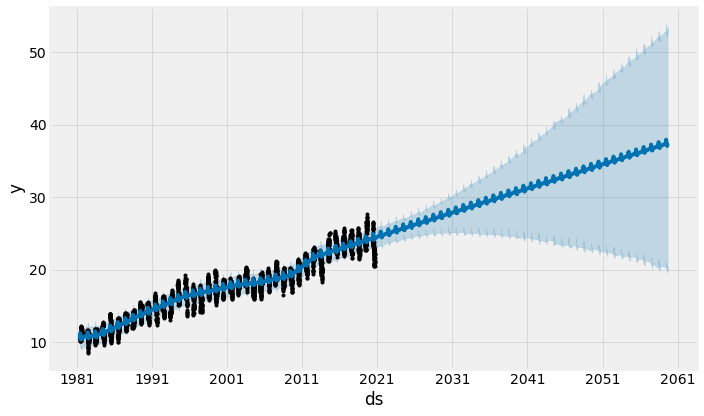

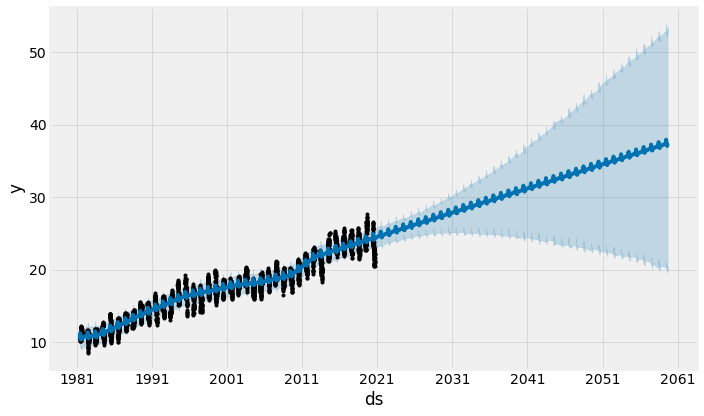

In [387]:
m_.plot(forecast_)

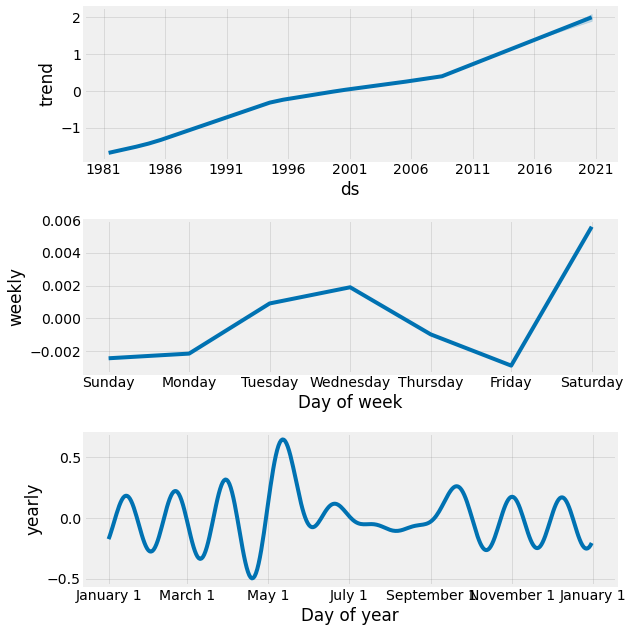

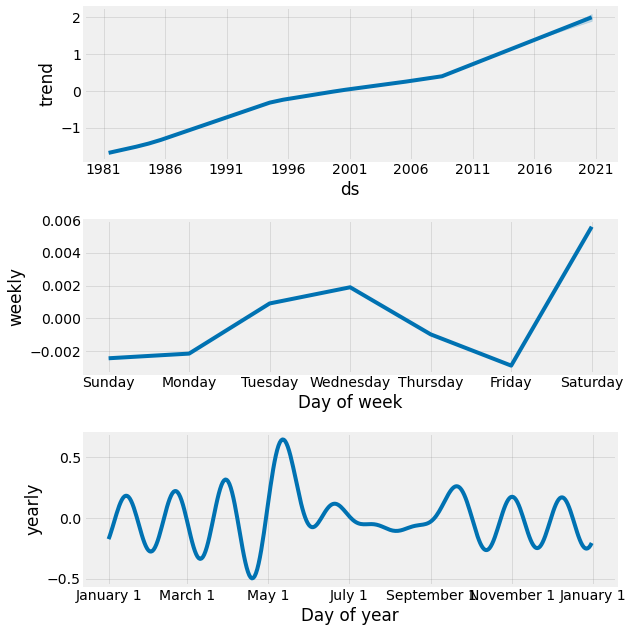

In [331]:
m.plot_components(forecast)

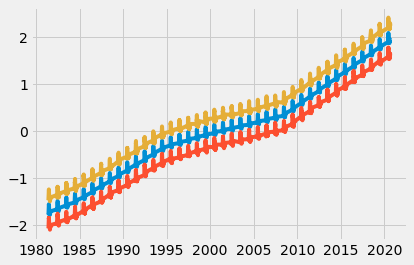

In [332]:
x1 = forecast['ds']
y1 = forecast['yhat']
y2 = forecast['yhat_lower']
y3 = forecast['yhat_upper']
plt.plot(x1,y1)
plt.plot(x1,y2)
plt.plot(x1,y3)
plt.show()

In [333]:
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

                      ds      yhat  yhat_lower  yhat_upper
0    1981-06-01 00:00:00 -1.740007   -2.066134   -1.466011
1    1981-06-02 00:00:00 -1.747712   -2.032875   -1.454530
2    1981-06-03 00:00:00 -1.752161   -2.043854   -1.452930
3    1981-06-04 00:00:00 -1.755472   -2.037090   -1.446017
4    1981-06-05 00:00:00 -1.753273   -2.058345   -1.464973
...                  ...       ...         ...         ...
3605 2020-08-30 00:06:00  1.956135    1.619455    2.253272
3606 2020-08-30 00:07:00  1.956133    1.623859    2.261541
3607 2020-08-30 00:08:00  1.956132    1.644823    2.289230
3608 2020-08-30 00:09:00  1.956130    1.655719    2.280247
3609 2020-08-30 00:10:00  1.956128    1.644747    2.282036

[3610 rows x 4 columns]
                      ds      yhat  yhat_lower  yhat_upper
3605 2020-08-30 00:06:00  1.956135    1.619455    2.253272
3606 2020-08-30 00:07:00  1.956133    1.623859    2.261541
3607 2020-08-30 00:08:00  1.956132    1.644823    2.289230
3608 2020-08-30 00:09:00  1.956

In [353]:
y_pred_ = forecast.iloc[-540:,[-1]]

In [354]:
y_pred_

,yhat
3070,1.314470
3071,1.331153
3072,1.357885
3073,1.367249
3074,1.383484
...,...
3605,1.956135
3606,1.956133
3607,1.956132
3608,1.956130


In [355]:
y_test = y_train_test

date
2015-06-01    48.50
2015-06-02    48.75
2015-06-03    48.60
2015-06-04    49.35
2015-06-05    49.25
              ...  
2020-08-26    49.90
2020-08-27    49.30
2020-08-28    49.10
2020-08-29    49.50
2020-08-30    49.45
Name: rolling_death, Length: 540, dtype: float64

In [357]:
mse_pro = mean_squared_error(y_true=y_test_, y_pred=y_pred_)
# 14.718074529657168
mae_pro = mean_absolute_error(y_true=y_test_, y_pred=y_pred_)
# 2.9980725916891813
mape_pro = mean_absolute_percentage_error(y_true=y_test_, y_pred=y_pred_)
# inf
# 因为 y_true 中含有 0

In [358]:
mse_pro

0.1457669487644386

In [359]:
mae_pro

0.29178536236574404

In [360]:
mape_pro

22.132598991270143

In [215]:
minimum = pd.read_csv('min.csv')
prep = pd.read_csv('pr.csv')
maximum = pd.read_csv('max.csv')
average = pd.read_csv('avg.csv')

In [219]:
maximum=maximum.iloc[:,1:]

In [220]:
minimum=minimum.iloc[:,1:]
prep=prep.iloc[:,1:]
average=average.iloc[:,1:]

In [223]:
dt = pd.merge(maximum,minimum,on='date',how='left')

In [224]:
dt = pd.merge(dt,average,on='date',how='left')

In [225]:
dt = pd.merge(dt,prep,on='date',how='left')

In [228]:
dt = dt.set_index('date')

In [231]:
dt_man = dt.loc[:,['year','month','day','man_max','man_min','man_avg','man_pr']]
dt_bir = dt.loc[:,['year','month','day','bir_max','bir_min','bir_avg','bir_pr']]
dt_new = dt.loc[:,['year','month','day','new_max','new_min','new_avg','new_pr']]

In [237]:
dt_man = dt_man[dt_man['month'].between(6,8)]
dt_bir = dt_bir[dt_bir['month'].between(6,8)]
dt_new = dt_new[dt_new['month'].between(6,8)]

In [374]:
dt_new

,year,month,day,new_max,new_min,new_avg,new_pr
date,,,,,,,
1981-06-01,1981,6,1,9.213539,6.399064,7.722356,0.347320
1981-06-02,1981,6,2,9.638519,6.864255,8.188110,0.290970
1981-06-03,1981,6,3,9.913733,6.557695,8.120584,0.399134
1981-06-04,1981,6,4,10.094293,7.237544,8.518219,0.174634
1981-06-05,1981,6,5,10.372019,7.330478,8.877575,0.431654
...,...,...,...,...,...,...,...
2059-08-26,2059,8,26,20.705507,14.606791,17.712194,0.057411
2059-08-27,2059,8,27,25.248159,14.954584,19.666977,0.004250
2059-08-28,2059,8,28,22.919563,15.015251,18.620476,0.284162


In [243]:
x_test_new = dt_new[dt_new['year'] > 2020]

In [283]:
x_test_bir = dt_bir[dt_bir['year'] > 2020]

In [232]:
train

,year,month,day,man_max,man_min,man_avg,man_pr
date,,,,,,,
1981-01-01,1981,1,1,4.408697,0.627823,2.803979,7.552406
1981-01-02,1981,1,2,0.601811,-6.034655,-2.329107,0.000153
1981-01-03,1981,1,3,2.566705,-5.856226,0.246915,1.571437
1981-01-04,1981,1,4,7.318420,2.340290,4.508552,0.301938
1981-01-05,1981,1,5,9.118712,4.667547,7.781409,14.465652
...,...,...,...,...,...,...,...
2059-12-26,2059,12,26,10.001223,6.704967,8.454183,0.141942
2059-12-27,2059,12,27,10.971631,6.259435,8.900743,10.320499
2059-12-28,2059,12,28,14.160928,6.121845,8.424746,32.056690


In [246]:
death_new_summer

,year,month,day,new_min,new_max,new_avg,new_pr,death_over85,rolling_death
date,,,,,,,,,
1981-06-01,1981.0,6.0,1.0,6.399064,9.213539,7.722356,0.347320,13,10.20
1981-06-02,1981.0,6.0,2.0,6.864255,9.638519,8.188110,0.290970,7,10.55
1981-06-03,1981.0,6.0,3.0,6.557695,9.913733,8.120584,0.399134,7,10.75
1981-06-04,1981.0,6.0,4.0,7.237544,10.094293,8.518219,0.174634,7,10.75
1981-06-05,1981.0,6.0,5.0,7.330478,10.372019,8.877575,0.431654,10,10.70
...,...,...,...,...,...,...,...,...,...
2020-08-26,2020.0,8.0,26.0,15.078363,23.775600,19.441055,0.193756,23,21.20
2020-08-27,2020.0,8.0,27.0,11.456134,19.858368,15.987433,0.022009,21,21.05
2020-08-28,2020.0,8.0,28.0,11.896063,22.073442,17.499405,8.274512,26,21.55


In [281]:
death_bir_summer

,year,month,day,bir_min,bir_max,bir_avg,bir_pr,death_over85,rolling_death
date,,,,,,,,,
1981-06-01,1981.0,6.0,1.0,7.138943,12.911530,9.613237,3.050909,18,21.50
1981-06-02,1981.0,6.0,2.0,7.945549,12.626352,10.162156,15.398354,20,21.30
1981-06-03,1981.0,6.0,3.0,7.956182,15.019295,11.262386,1.237225,28,21.25
1981-06-04,1981.0,6.0,4.0,8.036394,13.427114,10.329688,2.681326,21,21.25
1981-06-05,1981.0,6.0,5.0,8.287448,12.977115,10.331379,30.204716,16,21.20
...,...,...,...,...,...,...,...,...,...
2020-08-26,2020.0,8.0,26.0,15.059542,27.245346,21.157284,0.003642,56,49.90
2020-08-27,2020.0,8.0,27.0,15.623131,26.010891,20.781651,0.008886,39,49.30
2020-08-28,2020.0,8.0,28.0,15.372007,30.820614,22.854008,0.104716,46,49.10


In [282]:
temp_train_bir = death_bir_summer.loc[:,['rolling_death']]

In [254]:
temp_train_new = death_new_summer.loc[:,['rolling_death']]

In [376]:
dt_new['y'] = temp_train_new

In [377]:
dt_new

,year,month,day,new_max,new_min,new_avg,new_pr,y
date,,,,,,,,
1981-06-01,1981,6,1,9.213539,6.399064,7.722356,0.347320,10.20
1981-06-02,1981,6,2,9.638519,6.864255,8.188110,0.290970,10.55
1981-06-03,1981,6,3,9.913733,6.557695,8.120584,0.399134,10.75
1981-06-04,1981,6,4,10.094293,7.237544,8.518219,0.174634,10.75
1981-06-05,1981,6,5,10.372019,7.330478,8.877575,0.431654,10.70
...,...,...,...,...,...,...,...,...
2059-08-26,2059,8,26,20.705507,14.606791,17.712194,0.057411,NaN
2059-08-27,2059,8,27,25.248159,14.954584,19.666977,0.004250,NaN
2059-08-28,2059,8,28,22.919563,15.015251,18.620476,0.284162,NaN


In [256]:
temp_train_new

,rolling_death
date,
1981-06-01,10.20
1981-06-02,10.55
1981-06-03,10.75
1981-06-04,10.75
1981-06-05,10.70
...,...
2020-08-26,21.20
2020-08-27,21.05
2020-08-28,21.55


In [292]:
x_test_bir

,year,month,day,bir_max,bir_min,bir_avg,bir_pr,Prediction
date,,,,,,,,
2021-06-01,2021,6,1,15.382217,7.973577,11.850189,3.389040e-02,22.718237
2021-06-02,2021,6,2,18.580402,9.563325,14.383987,2.150986e-02,22.646612
2021-06-03,2021,6,3,19.108915,9.722795,14.927935,7.373029e-01,22.584223
2021-06-04,2021,6,4,18.156605,11.431698,14.652443,8.999794e-01,22.961172
2021-06-05,2021,6,5,14.983934,10.001564,12.314056,1.307600e+01,22.559484
...,...,...,...,...,...,...,...,...
2059-08-26,2059,8,26,25.635540,15.862627,20.552731,1.378852e-02,23.449837
2059-08-27,2059,8,27,28.331724,12.755657,20.666924,1.481727e-07,23.776726
2059-08-28,2059,8,28,26.243202,14.777720,19.774811,1.224608e+00,23.340113


In [301]:
y_test_bir

NameError: name 'y_test_bir' is not defined

In [303]:
X_train_test

,year,month,day,new_min,new_max,new_avg,new_pr
date,,,,,,,
2015-06-01,2015.0,6.0,1.0,10.003051,16.156668,12.981271,0.297460
2015-06-02,2015.0,6.0,2.0,7.206343,15.288678,11.967657,0.040607
2015-06-03,2015.0,6.0,3.0,9.710574,17.153021,13.259924,2.920082
2015-06-04,2015.0,6.0,4.0,7.406582,15.709403,12.358000,0.052103
2015-06-05,2015.0,6.0,5.0,8.956901,16.205948,12.992478,0.027766
...,...,...,...,...,...,...,...
2020-08-26,2020.0,8.0,26.0,15.078363,23.775600,19.441055,0.193756
2020-08-27,2020.0,8.0,27.0,11.456134,19.858368,15.987433,0.022009
2020-08-28,2020.0,8.0,28.0,11.896063,22.073442,17.499405,8.274512


In [306]:
x_test_bir

,year,month,day,bir_max,bir_min,bir_avg,bir_pr
date,,,,,,,
2021-06-01,2021,6,1,15.382217,7.973577,11.850189,3.389040e-02
2021-06-02,2021,6,2,18.580402,9.563325,14.383987,2.150986e-02
2021-06-03,2021,6,3,19.108915,9.722795,14.927935,7.373029e-01
2021-06-04,2021,6,4,18.156605,11.431698,14.652443,8.999794e-01
2021-06-05,2021,6,5,14.983934,10.001564,12.314056,1.307600e+01
...,...,...,...,...,...,...,...
2059-08-26,2059,8,26,25.635540,15.862627,20.552731,1.378852e-02
2059-08-27,2059,8,27,28.331724,12.755657,20.666924,1.481727e-07
2059-08-28,2059,8,28,26.243202,14.777720,19.774811,1.224608e+00


In [305]:
x_test_bir = x_test_bir.iloc[:,:-1]

In [307]:
model.predict(x_test_bir)

array([46.068977, 46.014137, 46.339546, ..., 46.917538, 47.158596,
       47.123585], dtype=float32)

In [308]:
temp_test_bir_ = model.predict(x_test_bir)

In [260]:
temp_test_new_ = model.predict(x_test_new)

In [309]:
len(temp_test_new_)

3510

In [264]:
temp_test

,rolling_death,Prediction
date,,
2015-06-01,25.05,23.111696
2015-06-02,24.75,21.485998
2015-06-03,24.70,22.668112
2015-06-04,24.65,21.386599
2015-06-05,24.90,22.721039
...,...,...
2020-08-26,21.20,23.056072
2020-08-27,21.05,24.008789
2020-08-28,21.55,23.201067


In [266]:
temp_test_new_

array([22.547392, 22.675997, 22.67651 , ..., 23.2482  , 24.158258,
       23.321913], dtype=float32)

In [270]:
x_test_new['Prediction'] = temp_test_new_

<ipython-input-270-835c87974921>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test_new['Prediction'] = temp_test_new_


In [312]:
temp_test_bir_

array([46.068977, 46.014137, 46.339546, ..., 46.917538, 47.158596,
       47.123585], dtype=float32)

In [313]:
x_test_bir['Prediction'] = temp_test_bir_

In [271]:
x_test_new

,year,month,day,new_max,new_min,new_avg,new_pr,Prediction
date,,,,,,,,
2021-06-01,2021,6,1,15.198137,5.161768,10.492437,0.037275,22.547392
2021-06-02,2021,6,2,15.984013,6.132723,11.644376,0.014923,22.675997
2021-06-03,2021,6,3,17.618128,7.037038,12.799665,3.325556,22.676510
2021-06-04,2021,6,4,19.403280,11.264265,15.219839,2.152464,22.883850
2021-06-05,2021,6,5,16.806650,10.230015,12.912457,6.586192,22.579992
...,...,...,...,...,...,...,...,...
2059-08-26,2059,8,26,20.705507,14.606791,17.712194,0.057411,23.149761
2059-08-27,2059,8,27,25.248159,14.954584,19.666977,0.004250,23.804655
2059-08-28,2059,8,28,22.919563,15.015251,18.620476,0.284162,23.248199


In [287]:
temp_train_bir

,rolling_death
date,
1981-06-01,21.50
1981-06-02,21.30
1981-06-03,21.25
1981-06-04,21.25
1981-06-05,21.20
...,...
2020-08-26,49.90
2020-08-27,49.30
2020-08-28,49.10


In [274]:
temp_test

,rolling_death,Prediction
date,,
2015-06-01,25.05,23.111696
2015-06-02,24.75,21.485998
2015-06-03,24.70,22.668112
2015-06-04,24.65,21.386599
2015-06-05,24.90,22.721039
...,...,...
2020-08-26,21.20,23.056072
2020-08-27,21.05,24.008789
2020-08-28,21.55,23.201067


In [315]:
x_test_bir_ = x_test_bir.iloc[:,[-1]]

In [314]:
x_test_new_ = x_test_new.iloc[:,[-1]]

In [316]:
x_test_bir_

,Prediction
date,
2021-06-01,46.068977
2021-06-02,46.014137
2021-06-03,46.339546
2021-06-04,46.327538
2021-06-05,45.926003
...,...
2059-08-26,46.851334
2059-08-27,46.796368
2059-08-28,46.917538


In [ ]:
x_test_bir

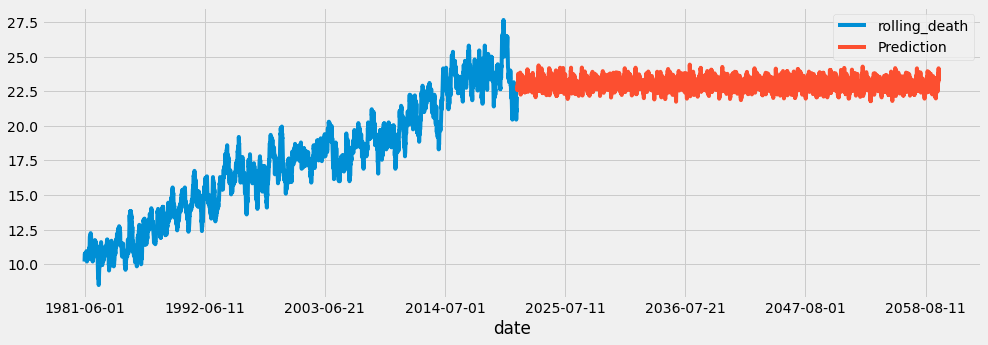

In [318]:
temp_all_new = pd.concat([temp_train_new,x_test_new_], sort=False)
__new = temp_all_new[['rolling_death','Prediction']].plot(figsize=(15, 5))

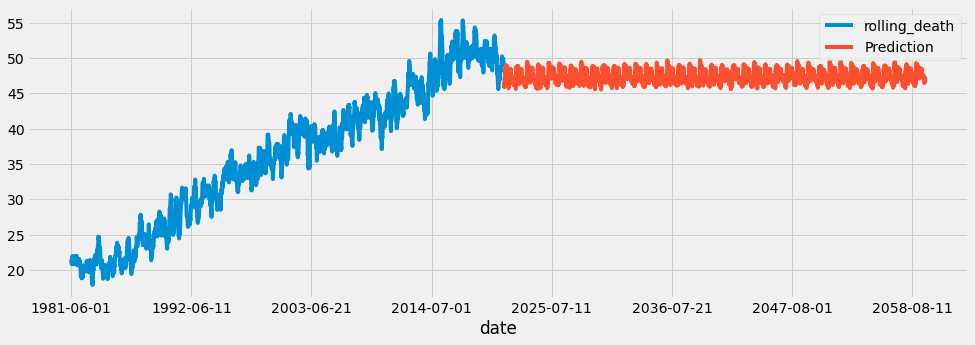

In [319]:
temp_all_bir = pd.concat([temp_train_bir,x_test_bir_], sort=False)
__bir = temp_all_bir[['rolling_death','Prediction']].plot(figsize=(15, 5))